In [1]:
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `ssh://git@github.com/JuliaRegistries/General.git`


In [2]:
using LinearAlgebra
using QPControl
using RigidBodyDynamics
using RigidBodyDynamics.PDControl
using RigidBodyDynamics.Contact
using StaticArrays
using AtlasRobot
using BenchmarkTools
using Test
using RigidBodySim

┌ Info: Recompiling stale cache file /home/twan/.julia/compiled/v1.1/QPControl/8tP2B.ji for QPControl [d1d18edd-2826-5709-814b-0b0c7d0d034b]
└ @ Base loading.jl:1184


HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/29d4a42ceb6d03d53ba5feb8981c0eb5bceb5139-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/29d4a42ceb6d03d53ba5feb8981c0eb5bceb5139-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

In [3]:
# load URDF
mechanism = AtlasRobot.mechanism()
remove_fixed_tree_joints!(mechanism);

In [4]:
# add environment
rootframe = root_frame(mechanism)
ground = HalfSpace3D(Point3D(rootframe, 0., 0., 0.), FreeVector3D(rootframe, 0., 0., 1.))
add_environment_primitive!(mechanism, ground);

In [5]:
# create optimizer
using MathOptInterface
using OSQP
using OSQP.MathOptInterfaceOSQP: OSQPSettings
const MOI = MathOptInterface
optimizer = OSQP.Optimizer()
MOI.set(optimizer, OSQPSettings.Verbose(), false)
MOI.set(optimizer, OSQPSettings.EpsAbs(), 1e-5)
MOI.set(optimizer, OSQPSettings.EpsRel(), 1e-5)
MOI.set(optimizer, OSQPSettings.MaxIter(), 5000)
MOI.set(optimizer, OSQPSettings.AdaptiveRhoInterval(), 25) # required for deterministic behavior

In [6]:
# create low level controller
const num_basis_vectors = 4
lowlevel = MomentumBasedController{num_basis_vectors}(mechanism, optimizer,
    floatingjoint = findjoint(mechanism, "pelvis_to_world"));
for body in bodies(mechanism)
    for point in RigidBodyDynamics.contact_points(body)
        position = location(point)
        normal = FreeVector3D(default_frame(body), 0.0, 0.0, 1.0)
        μ = point.model.friction.μ
        contact = addcontact!(lowlevel, body, position, normal, μ)
        contact.maxnormalforce[] = 1e6 # TODO
        contact.weight[] = 1e-3
    end
end

In [7]:
# state initialization
function initialize!(state::MechanismState)
    mechanism = state.mechanism
    zero!(state)
    kneebend = 1.1
    hipbendextra = 0.1
    for sideprefix in ('l', 'r')
        knee = findjoint(mechanism, "$(sideprefix)_leg_kny")
        hippitch = findjoint(mechanism, "$(sideprefix)_leg_hpy")
        anklepitch = findjoint(mechanism, "$(sideprefix)_leg_aky")
        set_configuration!(state, knee, [kneebend])
        set_configuration!(state, hippitch, [-kneebend / 2 + hipbendextra])
        set_configuration!(state, anklepitch, [-kneebend / 2 - hipbendextra])
    end
    floatingjoint = first(out_joints(root_body(mechanism), mechanism))
    set_configuration!(state, floatingjoint, [1; 0; 0; 0; 0; 0; 0.85])
    state
end

initialize! (generic function with 1 method)

In [8]:
# create standing controller
feet = findbody.(Ref(mechanism), ["l_foot", "r_foot"])
pelvis = findbody(mechanism, "pelvis")
nominalstate = MechanismState(mechanism)
initialize!(nominalstate)
controller = StandingController(lowlevel, feet, pelvis, nominalstate);

In [9]:
state = MechanismState(mechanism)
initialize!(state)
τ = similar(velocity(state));
benchresult = @benchmark $controller($τ, 0.0, $state)
@show benchresult.allocs
@test benchresult.allocs <= 24
benchresult

benchresult.allocs = 0


BenchmarkTools.Trial: 
  memory estimate:  0 bytes
  allocs estimate:  0
  --------------
  minimum time:     935.957 μs (0.00% GC)
  median time:      1.010 ms (0.00% GC)
  mean time:        1.008 ms (0.00% GC)
  maximum time:     1.440 ms (0.00% GC)
  --------------
  samples:          4944
  evals/sample:     1

In [10]:
# function test(τ, state, n)
#     for i = 1 : n
#         controller(τ, 0.0, state)
#     end
# end
# test(τ, state, 1)
# Profile.clear()
# @profile test(τ, state, 10000)
# using ProfileView
# ProfileView.view()

In [11]:
# #NBSKIP
# # set up visualizer
# using MeshCat
# using MeshCatMechanisms
# if !@isdefined(vis) || !any(isopen, vis.core.scope.pool.connections)
#     vis = Visualizer()[:atlas]
#     visuals = URDFVisuals(AtlasRobot.urdfpath(); package_path = [AtlasRobot.packagepath()])
#     mvis = MechanismVisualizer(mechanism, visuals, vis)
#     set_configuration!(mvis, configuration(nominalstate))
#     open(mvis)
#     wait(mvis)
# end

In [12]:
# simulate
state = MechanismState(mechanism)
initialize!(state)
Δt = 1 / 500
pcontroller = PeriodicController(similar(velocity(state)), Δt, controller)
# TODO: add damping
dynamics = Dynamics(mechanism, pcontroller)
problem = ODEProblem(dynamics, state, (0., 10.))

ODEProblem with uType Array{Float64,1} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: [1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.85, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

In [13]:
sol = solve(problem, Tsit5(), abs_tol = 1e-8, dt = 1e-6)
@time sol = solve(problem, Tsit5(), abs_tol = 1e-8, dt = 1e-6)
@test sol.retcode == :Success
copyto!(state, last(sol.u))
@test norm(velocity(state)) ≈ 0 atol=1e-8
@test center_of_mass(state).v[3] > 1

  6.888592 seconds (58.85 k allocations: 46.382 MiB, 0.52% gc time)


Test Passed

In [14]:
using Plots

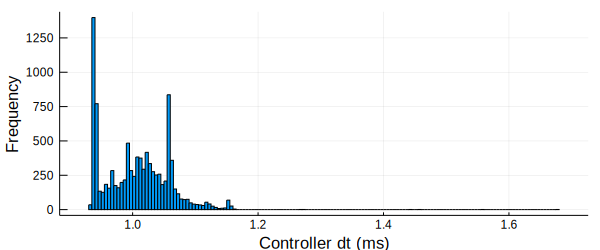

In [24]:
dts_after_startup = controller.dts[30:end] * 1e6
plt = histogram(dts_after_startup ./ 1000, legend=false, size=(600, 250), nbins=150)
xlabel!(plt, "Controller dt (ms)")
ylabel!(plt, "Frequency")
savefig("controller_dt_histogram.svg")
savefig("controller_dt_histogram.png")
plt

In [25]:
minimum(dts_after_startup)

932.9319000244141

In [26]:
maximum(dts_after_startup)

1677.9899597167969

In [16]:
# #NBSKIP
# setanimation!(mvis, sol)